In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score
import lightgbm as lgb
from tqdm import tqdm_notebook
import joblib
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows

60

In [2]:
#path = r'C:\\Users\\lixue\\OneDrive\\Desktop\\smu\\MQF\\Quantitative Research\\project_part2\\'
#df = pd.read_csv(path+'all_years_number_only.csv')
df = pd.read_csv('yearly_data.csv')

In [3]:
'''
cols = df.iloc[0,:]
df.set_axis(cols,axis=1,inplace=True)
df = df.iloc[1:,:]
df.reset_index(drop=True,inplace=True)
'''
df['IQ_RD_EXP'] = pd.to_numeric(df['IQ_RD_EXP'], errors='coerce')
df.columns.values[0] = "company"
df.replace('NM', np.nan,inplace=True)
df.replace('', np.nan,inplace=True)
df.replace(' ', np.nan,inplace=True)
tmp = np.where(df['IQ_RD_EXP']>0,1,0)
df.replace('0', np.nan,inplace=True)
df.replace(0, np.nan,inplace=True)
df['RD_EXP_CAT'] = tmp
df.head()

,company,company_name,period,IQ_RD_EXP,IQ_TOTAL_ASSETS,RnD_OVER_TA,industry,IQ_RETURN_ASSETS,IQ_RETURN_CAPITAL,IQ_RETURN_EQUITY,...,IQ_EBIT_3YR_ANN_CAGR,IQ_EARNING_CO_3YR_ANN_CAGR,IQ_NI_3YR_ANN_CAGR,IQ_NI_NORM_3YR_ANN_CAGR,IQ_EPS_3YR_ANN_CAGR,IQ_ACCT_RECV_3YR_ANN_CAGR,IQ_NPPE_3YR_ANN_CAGR,IQ_COMMON_EQUITY_3YR_ANN_CAGR,IQ_TOTAL_ASSETS_3YR_ANN_CAGR,RD_EXP_CAT
0,NasdaqGS:AAL,American Airlines Group Inc.,FY2021,NaN,66467.000,NaN,Industrials,-5.0369,-8.8658,NaN,...,NaN,NaN,NaN,NaN,NaN,-4.0925,-4.2274,NaN,3.1396,0
1,NasdaqGS:AAON,"AAON, Inc.",FY2021,NaN,650.180,NaN,Industrials,7.9570,9.9875,14.3832,...,7.5325,11.5517,11.5517,7.6102,10.861,12.2712,19.0505,23.1755,28.2814,0
2,NasdaqGS:AAPL,Apple Inc.,FY2021,21914.0,351002.000,0.062432693,Information Technology,20.1790,35.1694,147.4433,...,15.3975,16.7271,16.7271,14.4199,23.4759,4.2611,6.2388,-16.184,-1.3604,1
3,NasdaqGS:AAWW,"Atlas Air Worldwide Holdings, Inc.",FY2021,NaN,6443.243,NaN,Industrials,7.1307,8.5657,19.4568,...,34.1028,22.154,22.166,24.2689,45.7604,4.3372,-0.6936,10.7525,5.1964,0
4,NasdaqGS:ABCB,Ameris Bancorp,FY2021,NaN,23858.321,NaN,Financials,1.7017,NaN,13.4287,...,NaN,46.0336,46.0336,42.3617,24.474,NaN,NaN,26.7625,27.7498,0


In [4]:
df.describe()

,IQ_RD_EXP,IQ_TOTAL_ASSETS,IQ_RETURN_ASSETS,IQ_FIXED_ASSET_TURNS,IQ_CURRENT_RATIO,IQ_QUICK_RATIO,IQ_CFO_CURRENT_LIAB,IQ_TOTAL_LIAB_TOTAL_ASSETS,IQ_NPPE_1YR_ANN_GROWTH,IQ_TOTAL_ASSETS_1YR_ANN_GROWTH,IQ_NPPE_2YR_ANN_CAGR,IQ_TOTAL_ASSETS_2YR_ANN_CAGR,IQ_NPPE_3YR_ANN_CAGR,IQ_TOTAL_ASSETS_3YR_ANN_CAGR,RD_EXP_CAT
count,1.250000e+03,4.488000e+03,4271.000000,3205.000000,4145.000000,4140.000000,4057.000000,4147.000000,3313.000000,4.273000e+03,3265.000000,4122.000000,2928.000000,3807.000000,4647.000000
mean,3.486962e+03,1.062980e+06,0.752144,19.771479,6.069936,5.328635,-0.121357,58.519494,74.894347,7.374785e+03,36.819389,68.204329,32.367229,19.645997,0.268991
std,4.420541e+04,1.954769e+07,15.941558,358.718507,65.580996,64.740895,22.044222,34.713294,914.661970,9.883815e+04,231.754668,1368.410225,79.921718,59.050764,0.443483
min,4.000000e-03,4.312200e-01,-237.529600,0.001760,0.002330,0.001570,-1365.040000,0.091200,-100.000000,-9.362950e+01,-80.569100,-71.212200,-71.414100,-50.714300,0.000000
25%,3.208600e+01,5.915353e+02,-0.316050,1.039990,1.097770,0.680432,-0.118320,36.832800,-5.211000,1.651000e-01,-3.126700,0.819250,3.396175,1.380400,0.000000
50%,7.617750e+01,2.356528e+03,2.062100,3.869560,1.804080,1.230760,0.281280,56.896200,3.199000,8.541900e+00,6.242900,8.777200,13.777900,8.729700,0.000000
75%,2.539137e+02,1.070736e+04,5.329400,8.541210,3.326530,2.545710,0.718960,76.438550,20.789100,2.856360e+01,27.428000,24.504050,36.517575,20.160750,1.000000
max,1.222044e+06,6.638958e+08,342.233900,19593.300000,2344.092390,2316.051130,100.162530,1018.420700,37033.774800,3.848857e+06,7171.061400,61001.836800,1554.815600,1599.924800,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4647 entries, 0 to 4646
Data columns (total 86 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   company                          4647 non-null   object 
 1   company_name                     4647 non-null   object 
 2   period                           4647 non-null   object 
 3   IQ_RD_EXP                        1250 non-null   float64
 4   IQ_TOTAL_ASSETS                  4488 non-null   float64
 5   RnD_OVER_TA                      1409 non-null   object 
 6   industry                         4647 non-null   object 
 7   IQ_RETURN_ASSETS                 4271 non-null   float64
 8   IQ_RETURN_CAPITAL                3674 non-null   object 
 9   IQ_RETURN_EQUITY                 4010 non-null   object 
 10  IQ_RETURN_INVESTED_CAPITAL       3674 non-null   object 
 11  IQ_RETURN_COMMON_EQUITY          3927 non-null   object 
 12  IQ_GROSS_MARGIN     

In [6]:
Y = df.iloc[:,2:3]
X = df.iloc[:,3:]

In [7]:
df['RD_EXP_CAT']

0       0
1       0
2       1
3       0
4       0
       ..
4642    1
4643    1
4644    0
4645    0
4646    0
Name: RD_EXP_CAT, Length: 4647, dtype: int32

In [8]:
tmp = np.where(df['IQ_RD_EXP']>0,1,0)
Y_cat = pd.DataFrame(tmp,columns  = ['IQ_RD_EXP'])
Y_cat

,IQ_RD_EXP
0,0
1,0
2,1
3,0
4,0
...,...
4642,1
4643,1
4644,0
4645,0


### Data set EDA

In [9]:
# see portion of companies in each quater with R&D Expanse
#sns.countplot('IQ_RD_EXP',data = Y_cat)

In [10]:
X.columns

Index(['IQ_RD_EXP', 'IQ_TOTAL_ASSETS', 'RnD_OVER_TA', 'industry',
       'IQ_RETURN_ASSETS', 'IQ_RETURN_CAPITAL', 'IQ_RETURN_EQUITY',
       'IQ_RETURN_INVESTED_CAPITAL', 'IQ_RETURN_COMMON_EQUITY',
       'IQ_GROSS_MARGIN', 'IQ_EBITDA_MARGIN', 'IQ_EBITA_MARGIN',
       'IQ_EBIT_MARGIN', 'IQ_EARNING_CO_MARGIN', 'IQ_NI_MARGIN',
       'IQ_NI_NORM_MARGIN', 'IQ_NI_AVAIL_EXCL_MARGIN', 'IQ_LFCF_MARGIN',
       'IQ_UFCF_MARGIN', 'IQ_ASSET_TURNS', 'IQ_FIXED_ASSET_TURNS',
       'IQ_AR_TURNS', 'IQ_CURRENT_RATIO', 'IQ_QUICK_RATIO',
       'IQ_DAYS_SALES_OUT', 'IQ_DAYS_PAYABLE_OUT', 'IQ_CFO_CURRENT_LIAB',
       'IQ_TOTAL_DEBT_EQUITY', 'IQ_TOTAL_DEBT_CAPITAL', 'IQ_LT_DEBT_EQUITY',
       'IQ_LT_DEBT_CAPITAL', 'IQ_TOTAL_LIAB_TOTAL_ASSETS', 'IQ_EBIT_INT',
       'IQ_EBITDA_INT', 'IQ_EBITDA_CAPEX_INT', 'IQ_TOTAL_DEBT_EBITDA',
       'IQ_NET_DEBT_EBITDA', 'IQ_TOTAL_DEBT_EBITDA_CAPEX',
       'IQ_NET_DEBT_EBITDA_CAPEX', 'IQ_Z_SCORE', 'IQ_CAPEX_PCT_REV',
       'IQ_TOTAL_REV_1YR_ANN_GROWTH', 'IQ_GP_1YR

In [11]:
#X['IQ_RETURN_ASSETS'].plot(kind='hist',bins=100,figsize=(15,5),title='distr of IQ_RETURN_ASSETS')

In [12]:
'''
item = 'IQ_RETURN_ASSETS'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
df.loc[df['RD_EXP_CAT']==1][item].plot(kind='hist',
                                       bins=100,
                                       title = f'{item} RE_EXP_CAT = 1',
                                       ax=ax1)

df.loc[df['RD_EXP_CAT']==0][item].plot(kind='hist',
                                       bins=100,
                                       title = f'{item} RE_EXP_CAT = 0',
                                       ax = ax2)

plt.show()
'''

"\nitem = 'IQ_RETURN_ASSETS'\nfig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))\ndf.loc[df['RD_EXP_CAT']==1][item].plot(kind='hist',\n                                       bins=100,\n                                       title = f'{item} RE_EXP_CAT = 1',\n                                       ax=ax1)\n\ndf.loc[df['RD_EXP_CAT']==0][item].plot(kind='hist',\n                                       bins=100,\n                                       title = f'{item} RE_EXP_CAT = 0',\n                                       ax = ax2)\n\nplt.show()\n"

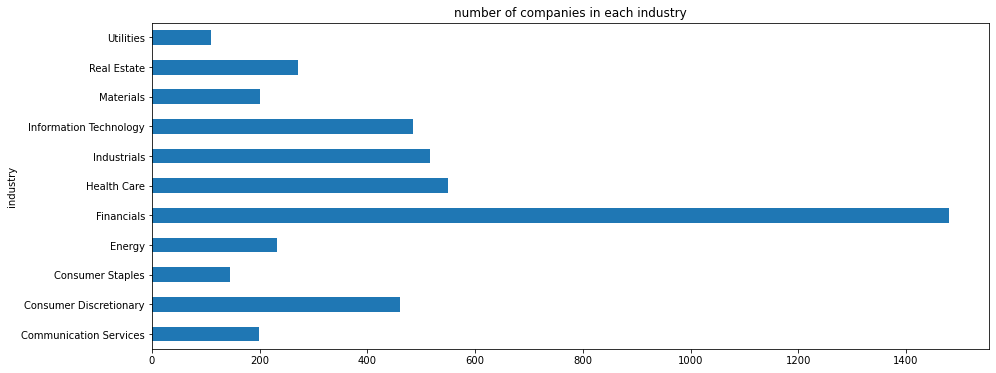

In [13]:
df.groupby('industry')['company'].count().plot(kind='barh',
                                          figsize=(15,6),
                                          title = 'number of companies in each industry')

plt.show()

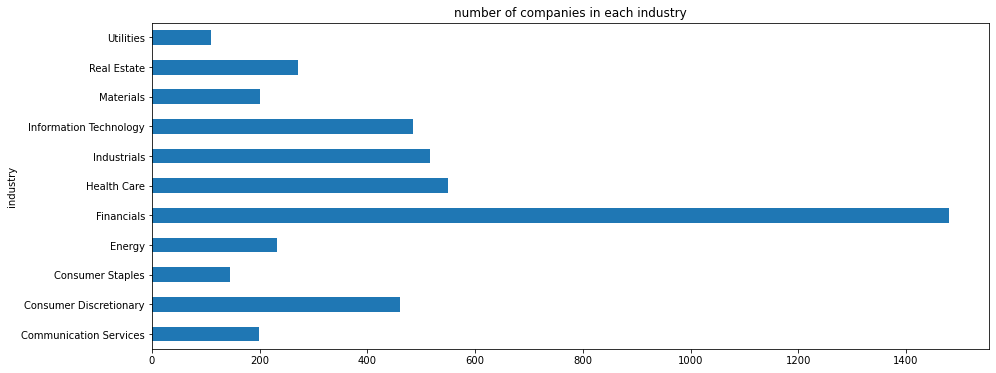

In [14]:
df.groupby('industry')['RD_EXP_CAT'].count().plot(kind='barh',
                                          figsize=(15,6),
                                          title = 'number of companies in each industry')

plt.show()

In [15]:
### LabelEncoder convert categorical type data
i = 0
for col in df.columns:
    if df[col].dtype == "object":
        print(col)
        i = i+1
print(i)

company
company_name
period
RnD_OVER_TA
industry
IQ_RETURN_CAPITAL
IQ_RETURN_EQUITY
IQ_RETURN_INVESTED_CAPITAL
IQ_RETURN_COMMON_EQUITY
IQ_GROSS_MARGIN
IQ_EBITDA_MARGIN
IQ_EBITA_MARGIN
IQ_EBIT_MARGIN
IQ_EARNING_CO_MARGIN
IQ_NI_MARGIN
IQ_NI_NORM_MARGIN
IQ_NI_AVAIL_EXCL_MARGIN
IQ_LFCF_MARGIN
IQ_UFCF_MARGIN
IQ_ASSET_TURNS
IQ_AR_TURNS
IQ_DAYS_SALES_OUT
IQ_DAYS_PAYABLE_OUT
IQ_TOTAL_DEBT_EQUITY
IQ_TOTAL_DEBT_CAPITAL
IQ_LT_DEBT_EQUITY
IQ_LT_DEBT_CAPITAL
IQ_EBIT_INT
IQ_EBITDA_INT
IQ_EBITDA_CAPEX_INT
IQ_TOTAL_DEBT_EBITDA
IQ_NET_DEBT_EBITDA
IQ_TOTAL_DEBT_EBITDA_CAPEX
IQ_NET_DEBT_EBITDA_CAPEX
IQ_Z_SCORE
IQ_CAPEX_PCT_REV
IQ_TOTAL_REV_1YR_ANN_GROWTH
IQ_GP_1YR_ANN_GROWTH
IQ_EBITDA_1YR_ANN_GROWTH
IQ_EBITA_1YR_ANN_GROWTH
IQ_EBIT_1YR_ANN_GROWTH
IQ_EARNING_CO_1YR_ANN_GROWTH
IQ_NI_1YR_ANN_GROWTH
IQ_NI_NORM_1YR_ANN_GROWTH
IQ_EPS_1YR_ANN_GROWTH
IQ_ACCT_RECV_1YR_ANN_GROWTH
IQ_COMMON_EQUITY_1YR_ANN_GROWTH
IQ_CFO_1YR_ANN_GROWTH
IQ_CAPEX_1YR_ANN_GROWTH
IQ_TOTAL_REV_2YR_ANN_CAGR
IQ_GP_2YR_ANN_CAGR
IQ_EBITDA_2YR_

In [16]:
### count number of NaN, if more than 30%, remove such column
def clean_nan(df):
    tmp_cols = []
    for col in df.columns:
        counter = df[col].isnull().sum()
        ratio = counter / len(df[col])
        if ratio > 0.3:
            tmp_cols.append(col)
    print(tmp_cols)     
    new_df = df.drop(tmp_cols,axis=1)
    return new_df

In [17]:
### count number of zero, if more than 30%, remove such column
def clean_zero(df):
    tmp_cols = []
    for col in df.columns:
        counter = (df[col] == 0).sum()
        ratio = counter / len(df[col])
        if ratio > 0.3:
            tmp_cols.append(col)     
    new_df = df.drop(tmp_cols,axis=1)
    print(tmp_cols)
    return new_df

In [18]:
# Delete rows containing either 30% or more than 30% NaN Values
perc = 30.0 # Here N is 75
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
df = df.dropna( axis=0, 
                    thresh=min_count)

In [19]:
print('original shape: ',df.shape)
df = clean_nan(df)

original shape:  (2590, 86)
['IQ_RD_EXP', 'RnD_OVER_TA', 'IQ_EARNING_CO_1YR_ANN_GROWTH', 'IQ_NI_1YR_ANN_GROWTH', 'IQ_EPS_1YR_ANN_GROWTH']


In [20]:
### for those columns with majority element that is 
### more than 90% of the whole column, remove the column

def clean_top_cols(df):
    cols_to_remove = [col for col in df.columns if df[col].value_counts(dropna=False,normalize=True).values[0]>0.9]
    return cols_to_remove

In [21]:
col_to_remove = clean_top_cols(df)
len(col_to_remove)

1

In [22]:
### note dont remove the target col
col_to_remove

['period']

In [23]:
df = df.drop(col_to_remove,axis=1)


In [24]:
### LabelEncoder
# encoder = LabelEncoder()

# encoder.fit(list(df['industry'].values))
# df['industry'] = encoder.transform(list(df['industry'].values))

# encoder.fit(list(df['quarter'].values))
# df['quarter'] = encoder.transform(list(df['quarter'].values))

# encoder.fit(list(df['company'].values))
# df['company'] = encoder.transform(list(df['company'].values))

        
df = df.reset_index()

In [25]:
set(df.industry)

{'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities'}

In [26]:
cols = ['industry_Communication Services','industry_Consumer Discretionary','industry_Consumer Staples',
        'industry_Energy','industry_Financials','industry_Health Care','industry_Industrials','industry_Information Technology',
        'industry_Materials','industry_Real Estate','industry_Utilities']
tmp = pd.get_dummies(pd.DataFrame(df['industry']))[cols]
df = pd.concat([df,tmp],axis=1)
df

,index,company,company_name,IQ_TOTAL_ASSETS,industry,IQ_RETURN_ASSETS,IQ_RETURN_CAPITAL,IQ_RETURN_EQUITY,IQ_RETURN_INVESTED_CAPITAL,IQ_RETURN_COMMON_EQUITY,...,industry_Consumer Discretionary,industry_Consumer Staples,industry_Energy,industry_Financials,industry_Health Care,industry_Industrials,industry_Information Technology,industry_Materials,industry_Real Estate,industry_Utilities
0,1,NasdaqGS:AAON,"AAON, Inc.",650.180,Industrials,7.9570,9.9875,14.3832,8.8638,14.3832,...,0,0,0,0,0,1,0,0,0,0
1,2,NasdaqGS:AAPL,Apple Inc.,351002.000,Information Technology,20.1790,35.1694,147.4433,41.4292,147.4433,...,0,0,0,0,0,0,1,0,0,0
2,3,NasdaqGS:AAWW,"Atlas Air Worldwide Holdings, Inc.",6443.243,Industrials,7.1307,8.5657,19.4568,9.5024,19.4568,...,0,0,0,0,0,1,0,0,0,0
3,5,NasdaqGS:ABCL,AbCellera Biologics Inc.,1318.569,Health Care,10.9941,13.4432,16.5349,16.1481,16.5349,...,0,0,0,0,1,0,0,0,0,0
4,7,NasdaqGS:ABMD,"Abiomed, Inc.",1494.359,Health Care,10.7376,12.0391,18.8318,18.6555,18.8318,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,4637,NYSE:ZIM,ZIM Integrated Shipping Services Ltd.,9841.838,Industrials,57.2751,72.3335,190.7739,86.5651,190.9877,...,0,0,0,0,0,1,0,0,0,0
2586,4638,NYSE:ZIP,"ZipRecruiter, Inc.",398.619,Communication Services,5.2720,8.0701,2.2393,1.8045,2.114,...,0,0,0,0,0,0,0,0,0,0
2587,4639,NYSE:ZNH,China Southern Airlines Company Limited,322948.000,Industrials,-1.6598,-1.8959,-13.0224,-6.4961,-17.6735,...,0,0,0,0,0,1,0,0,0,0
2588,4640,NYSE:ZTO,ZTO Express (Cayman) Inc.,62772.343,Industrials,5.6393,6.5841,9.5918,6.5103,9.7418,...,0,0,0,0,0,1,0,0,0,0


In [27]:
#fill with column mean values
df = df.apply(pd.to_numeric, errors='coerce')
df.dtypes
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [28]:
#df.to_csv('final.csv')